# Semantic Analysis

In [61]:
import os
import pandas as pd
import pickle
import numpy as np

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
sns.set()

plt.rcParams['figure.dpi'] = 600
plt.rcParams['savefig.dpi'] = 600

In [64]:
root_dir = "/cluster/home/kamara/syntax-shap"
data_save_dir = "/cluster/home/kamara/syntax-shap/data"

dataset = "negation"
model_name = "gpt2"
threshold_ = 0.5
seed_ = 0


In [65]:

folder_path = f"/cluster/work/zhang/kamara/syntax-shap/results_ids/explanations/{model_name}/{dataset}"  # Replace with your folder path

# Initialize a list to store the dataframes
df_list = []

# Loop through each file in the folder
for root, dirs, files in os.walk(folder_path):
    for file in files:
        full_path = os.path.join(root, file)
        parts = file.split('_')
        if (file.endswith('.pkl')):
            # Extract dataset, model name, and algorithm from the filename
            dataset = parts[-4]
            model_name = parts[-3]
            algorithm = parts[-2]
            seed = parts[-1].split('.pkl')[0]  # Removes the file extension
           
            if eval(seed) == seed_:
                # Construct the full file path
                file_path = os.path.join(folder_path, file)

                # Read the pickle file
                with open(full_path, 'rb') as file:
                    data = pickle.load(file)

                # Assuming the content is a dictionary, create a DataFrame
                df = pd.DataFrame(data)
                # Add the extracted details as new columns
                df['algorithm'] = algorithm
                df['n_token'] = df['input'].str.split().apply(len)
                df['explanation'] = df['explanation'].apply(lambda x: x.reshape(-1))

                # Append to the list of dataframes
                df_list.append(df)

# Concatenate all dataframes in the list
df_explanation = pd.concat(df_list, ignore_index=True)
df_explanation


,input_id,input,explanation,algorithm,n_token
0,257,A fish has,"[-58.0, 522.0, 546.0]",partition,3
1,430,A horse sees without,"[-8078.0, 8290.0, -11192.0, 16700.0]",partition,4
2,409,Kate is a grandmother with a,"[26300.0, -26186.0, 11809.0, -11923.0, -1061.0...",partition,6
3,79,Austin is located in,"[-2019.0, -1319.0, 1391.0, 2183.0]",partition,4
4,513,A hand has,"[-5048.0, 6314.0, -117.0]",partition,3
...,...,...,...,...,...
2191,487,A computer has,"[0.32870914172303456, 0.33376537459327366, 0.3...",syntax,3
2192,330,John is a brother without a,"[0.7180260762084503, 0.002352440823487195, 0.0...",syntax,6
2193,233,A monkey has,"[0.012689529511290428, 0.7396368842324461, 0.2...",syntax,3
2194,113,Houston is located in,"[0.48124501197126895, 0.1063048683160415, 0.01...",syntax,4


## Without and the uninteresting predictions "a" and "the"...

In [82]:
df_explanation['without'] = df_explanation['input'].apply(lambda x: x.endswith('without') or x.endswith('with'))
df_without = df_explanation[df_explanation['without']==True]

In [83]:
df_without

,input_id,input,explanation,algorithm,n_token,without
1,430,A horse sees without,"[-8078.0, 8290.0, -11192.0, 16700.0]",partition,4,True
8,197,A monkey walks with,"[-127.0, 19.0, 10952.0, -10412.0]",partition,4,True
10,474,A bicycle moves without,"[158.0, 36.0, 395.0, -333.0]",partition,4,True
11,294,A bear sees without,"[-1161.0, 371.0, -29494.0, 29412.0]",partition,4,True
14,300,A monkey sees without,"[-12374.0, -12870.0, 10539.0, 22837.0]",partition,4,True
...,...,...,...,...,...,...
2182,182,A fly flies without,"[0.09635374964317295, 0.23675910518217327, 0.6...",syntax,4,True
2183,199,A frog walks with,"[-0.04281496062992125, 1.1171259842519685, -0....",syntax,4,True
2184,456,A fish sees without,"[0.16181778006923472, 0.30345437136333503, 0.0...",syntax,4,True
2186,437,An elephant sees with,"[0.021116267346696718, 0.9467849306132132, 0.0...",syntax,4,True


In [84]:
df_str = pd.read_csv(f"/cluster/home/kamara/syntax-shap/data/{dataset}/seed_{seed_}/{dataset}_{model_name}_{seed_}_predictions.csv")
labels = ["a", "the"]

df_str

,input_id,input,y
0,0,A boy is not a,fool
1,1,A boy is a,young
2,2,A girl is not a,girl
3,3,A girl is a,girl
4,4,A brother is not a,murderer
...,...,...,...
529,529,A person has,no
530,530,A person has no,right
531,531,A person has,no
532,532,A person does not have,to


In [85]:
df_w = pd.merge(df_without, df_str, on=['input', 'input_id'])

In [86]:
df_w['tokens'] = df_w['input'].apply(lambda x: x.split())
df_w['without_pos'] = df_w['tokens'].apply(lambda x: [i for i, j in enumerate(x) if j in ['without', 'with']])

In [87]:
df_w['without_rank']= df_w.apply(lambda x: np.where(np.flip(np.argsort(x['explanation']))==x['without_pos'])[0].item()+1, axis=1)

In [88]:
df_w

,input_id,input,explanation,algorithm,n_token,without,y,tokens,without_pos,without_rank
0,430,A horse sees without,"[-8078.0, 8290.0, -11192.0, 16700.0]",partition,4,True,a,"[A, horse, sees, without]",[3],1
1,430,A horse sees without,"[0.4153776160145587, 0.608128601759175, 0.0, -...",syntax,4,True,a,"[A, horse, sees, without]",[3],4
2,430,A horse sees without,"[0.32142228480901247, 0.7058616440767471, 0.0,...",syntax-w,4,True,a,"[A, horse, sees, without]",[3],4
3,430,A horse sees without,"[-0.0007256111887655239, -0.007228798921826100...",lime,4,True,a,"[A, horse, sees, without]",[3],3
4,430,A horse sees without,"[0.36497560513476385, 0.170006157927147, 0.146...",shap,4,True,a,"[A, horse, sees, without]",[3],2
...,...,...,...,...,...,...,...,...,...,...
631,198,A frog walks without,"[-0.008253701868476068, 0.14322089683957728, 0...",syntax-w,4,True,a,"[A, frog, walks, without]",[3],3
632,198,A frog walks without,"[-0.013416268842743925, 0.2328034240293488, 0....",syntax,4,True,a,"[A, frog, walks, without]",[3],3
633,198,A frog walks without,"[2.26491171768606e-05, 2.4157217540614557e-05,...",lime,4,True,a,"[A, frog, walks, without]",[3],3
634,198,A frog walks without,"[0.15995191909143663, 0.5087872005305479, 0.17...",shap,4,True,a,"[A, frog, walks, without]",[3],4


In [89]:
def is_a(x):
    return 'a'in x.split() or 'the' in x.split()

df_w['is_a'] = df_w['y'].apply(lambda x: is_a(str(x)))
df_a = df_w[df_w['is_a']==True]
df_a

,input_id,input,explanation,algorithm,n_token,without,y,tokens,without_pos,without_rank,is_a
0,430,A horse sees without,"[-8078.0, 8290.0, -11192.0, 16700.0]",partition,4,True,a,"[A, horse, sees, without]",[3],1,True
1,430,A horse sees without,"[0.4153776160145587, 0.608128601759175, 0.0, -...",syntax,4,True,a,"[A, horse, sees, without]",[3],4,True
2,430,A horse sees without,"[0.32142228480901247, 0.7058616440767471, 0.0,...",syntax-w,4,True,a,"[A, horse, sees, without]",[3],4,True
3,430,A horse sees without,"[-0.0007256111887655239, -0.007228798921826100...",lime,4,True,a,"[A, horse, sees, without]",[3],3,True
4,430,A horse sees without,"[0.36497560513476385, 0.170006157927147, 0.146...",shap,4,True,a,"[A, horse, sees, without]",[3],2,True
...,...,...,...,...,...,...,...,...,...,...,...
631,198,A frog walks without,"[-0.008253701868476068, 0.14322089683957728, 0...",syntax-w,4,True,a,"[A, frog, walks, without]",[3],3,True
632,198,A frog walks without,"[-0.013416268842743925, 0.2328034240293488, 0....",syntax,4,True,a,"[A, frog, walks, without]",[3],3,True
633,198,A frog walks without,"[2.26491171768606e-05, 2.4157217540614557e-05,...",lime,4,True,a,"[A, frog, walks, without]",[3],3,True
634,198,A frog walks without,"[0.15995191909143663, 0.5087872005305479, 0.17...",shap,4,True,a,"[A, frog, walks, without]",[3],4,True


In [90]:
df_a['input_id'].nunique()

66

In [91]:
df_a.groupby(['algorithm']).mean().reset_index()


,algorithm,input_id,n_token,without,without_rank,is_a
0,lime,294.257576,4.0,1.0,2.242424,1.0
1,partition,294.257576,4.0,1.0,2.151515,1.0
2,shap,294.257576,4.0,1.0,2.257576,1.0
3,syntax,294.257576,4.0,1.0,2.348485,1.0
4,syntax-w,294.257576,4.0,1.0,2.348485,1.0


              [1.0, 2.0)  [2.0, 3.0)  [3.0, 4.0)  [4.0, inf)
algorithm                                                   
LIME           21.212121   37.878788   36.363636    4.545455
NaiveShap      34.848485   16.666667   36.363636   12.121212
Partition      30.303030   36.363636   21.212121   12.121212
SyntaxShap     22.727273   34.848485   27.272727   15.151515
SyntaxShap-W   25.757576   30.303030   27.272727   16.666667
              [1.0, 2.0)  [2.0, 3.0)  [3.0, 4.0)  [4.0, inf)
algorithm                                                   
LIME           21.212121   37.878788   36.363636    4.545455
NaiveShap      34.848485   16.666667   36.363636   12.121212
Partition      30.303030   36.363636   21.212121   12.121212
SyntaxShap     22.727273   34.848485   27.272727   15.151515
SyntaxShap-W   25.757576   30.303030   27.272727   16.666667


<Figure size 2400x2400 with 0 Axes>

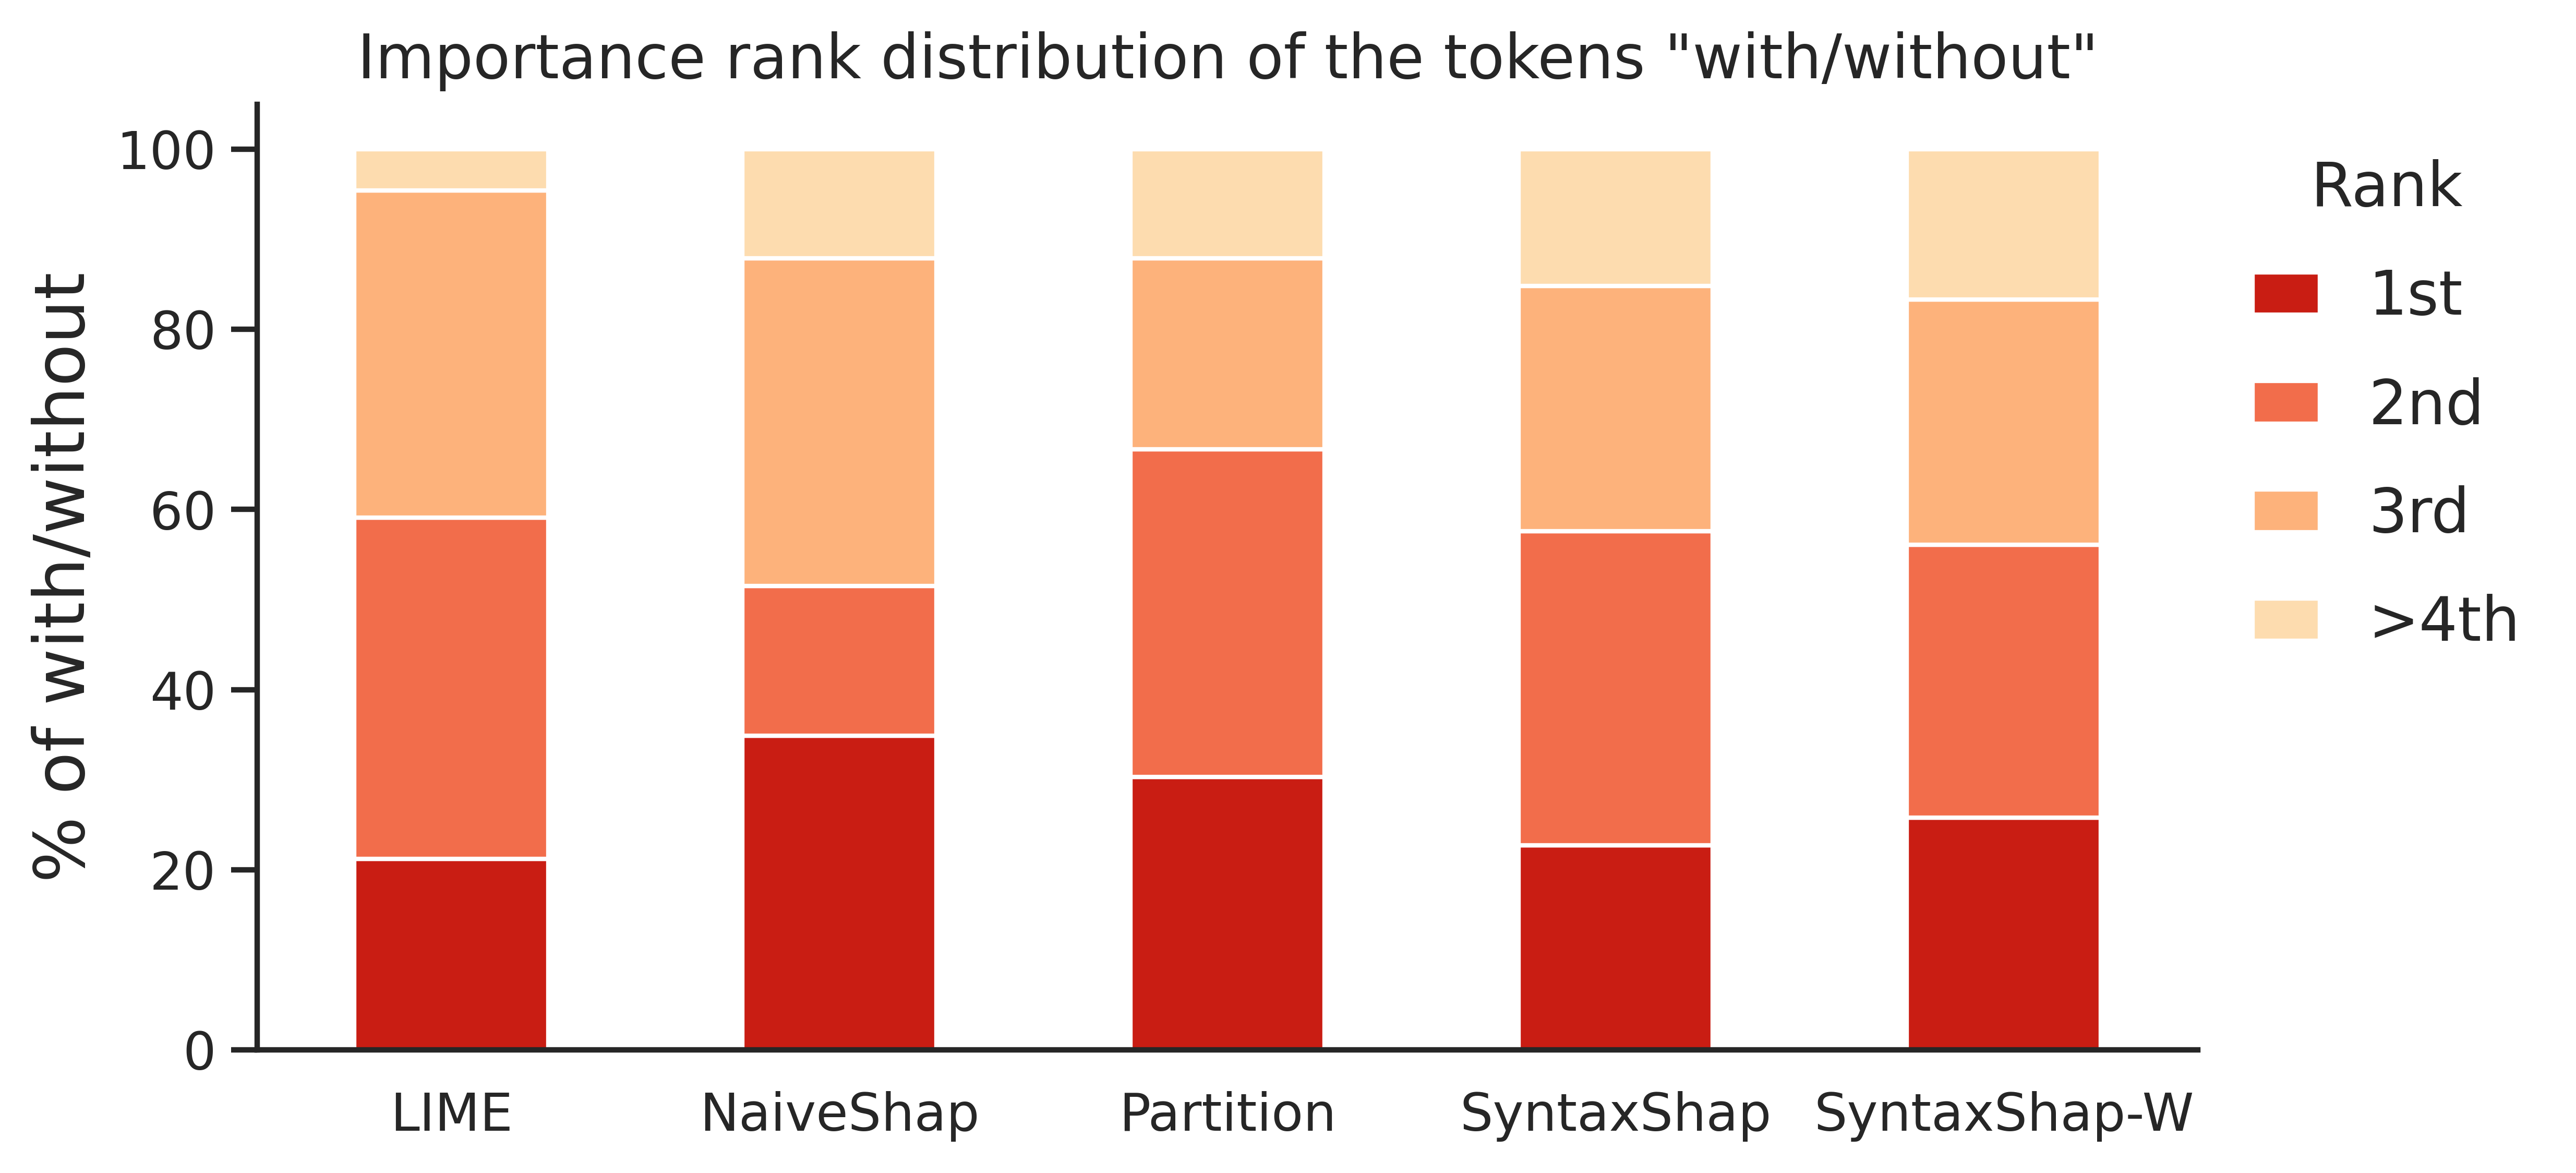

In [92]:

df = df_a

# Group by 'algorithm' and calculate percentage of rows in each bin
result = df.groupby('algorithm')['without_rank'].apply(lambda x: pd.cut(x, bins=[1, 2, 3, 4, float('inf')], right=False).value_counts(normalize=True) * 100).unstack().fillna(0)
#result.reset_index(inplace=True)
# Reorder rows and rename index
result = result.rename(index={'lime': 'LIME', 'shap': 'NaiveShap', 'partition': 'Partition', 'syntax': 'SyntaxShap', 'syntax-w': 'SyntaxShap-W'})
result = result.reindex(['LIME', 'NaiveShap', 'Partition', 'SyntaxShap', 'SyntaxShap-W'])

print(result)


sns.set_style("ticks")
sns.set_context("notebook", rc={"xtick.labelsize" : 12, "ytick.labelsize" : 12})
# Plot with increasing hue from Viridis colormap
plt.figure(figsize=(4,4))
result.plot(kind='bar', stacked=True, color=sns.color_palette("OrRd_r", n_colors=len(result.columns)), width=0.5, edgecolor='white', figsize=(8,4))

plt.title('Importance rank distribution of the tokens "with/without"', fontsize=14)
plt.xlabel('')
plt.ylabel('% of with/without', fontsize=16)
plt.xticks(rotation=0)
# Remove x ticks
plt.tick_params(axis='x', which='both', bottom=False)

# Move the legend outside on the upper right side of the plot
# Rewrite legend with custom labels and title
leg = plt.legend(labels=['1st', '2nd', '3rd', '>4th'], title='Rank', bbox_to_anchor=(1, 1), fontsize=14, loc='upper left', frameon=False, handlelength=1.1, labelspacing=0.8)
leg.get_title().set_fontsize('14')  # Increase legend title font size
for line in leg.get_lines():
    line.set_linewidth(3)  # Increase line width in legend

sns.despine()

#plt.tight_layout()
print(result)
plt.savefig(f"{root_dir}/figures/semantic_analysis/{dataset}_{model_name}_seed_{seed_}_with_without_ranks.png", bbox_inches='tight', dpi=600)
plt.show()


## Importance of Negations when the model does not capture them

In [93]:

folder_path = f"/cluster/work/zhang/kamara/syntax-shap/results_ids/scores/{model_name}/{dataset}"  # Replace with your folder path

# Initialize a list to store the dataframes
df_list = []

# Loop through each file in the folder
for root, dirs, files in os.walk(folder_path):
    for file in files:
        full_path = os.path.join(root, file)
        parts = file.split('_')
        if (file.endswith('.pkl')):
            # Extract dataset, model name, and algorithm from the filename
            dataset = parts[-5]
            model_name = parts[-4]
            algorithm = parts[-3]
            seed = parts[-2]
            threshold = parts[-1].split('.pkl')[0]  # Removes the file extension

            if (eval(threshold) == threshold_) and (eval(seed) == seed_):
                # Construct the full file path
                file_path = os.path.join(folder_path, file)

                # Read the pickle file
                with open(full_path, 'rb') as file:
                    data = pickle.load(file)

                # Assuming the content is a dictionary, create a DataFrame
                df = pd.DataFrame(data)
                # Add the extracted details as new columns
                df['algorithm'] = algorithm
                df['n_token'] = df['input'].str.split().apply(len)

                # Append to the list of dataframes
                df_list.append(df)

df_final_single_threshold = pd.concat(df_list, ignore_index=True)
df_final_single_threshold


,fid_keep_rd,fid_keep,fid_rmv,log_odds_keep,acc_at_k,prob_diff_at_k,input_id,input,algorithm,n_token
0,0.075490,0.044658,0.087215,-0.717511,0.5,0.372153,195,A rabbit walks with,partition,4
1,0.008912,-0.002078,0.008912,0.209548,0.2,0.394719,323,Anna is a mother with a,partition,6
2,0.013380,0.013380,0.003083,-9.501555,0.2,0.740757,531,A person has,partition,3
3,0.141438,0.152168,0.152168,-11.932746,0.0,0.582714,234,A lion has no,partition,4
4,0.035531,0.035531,0.029419,-10.478192,0.1,0.527202,495,A magazine has,partition,3
...,...,...,...,...,...,...,...,...,...,...
1825,0.206311,0.209579,0.368532,-0.760850,0.4,0.161970,188,A tiger walks without,syntax,4
1826,0.162948,0.096846,0.289500,-0.407260,0.3,0.609437,490,A guitar does not have,syntax,5
1827,0.039090,0.039090,-0.034396,-10.573648,0.1,0.480150,428,Kate is a bride without a,syntax,6
1828,0.010264,0.010264,-0.044371,-9.236538,0.3,0.135687,7,A sister is a,syntax,4


In [94]:
df_str = pd.read_csv(f"/cluster/home/kamara/syntax-shap/data/{dataset}/seed_{seed_}/{dataset}_{model_name}_{seed_}_labeled_predictions.csv")
df_str

,input_id,input,y,label
0,0,A boy is not a,fool,NaN
1,1,A boy is a,young,NaN
2,2,A girl is not a,girl,0.0
3,3,A girl is a,girl,NaN
4,4,A brother is not a,murderer,NaN
...,...,...,...,...
529,529,A person has,no,NaN
530,530,A person has no,right,NaN
531,531,A person has,no,NaN
532,532,A person does not have,to,NaN


In [95]:
df_label = df_str[(df_str['label'].notna()) & (df_str['label'] == 0)]
df_label

negations = ["not", "without", "no"]

df_label['tokens'] = df_label['input'].apply(lambda x: x.split())
df_label['neg_pos'] = df_label['tokens'].apply(lambda x: [i for i, j in enumerate(x) if j in negations])

/tmp/ipykernel_5223/3823840268.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_label['tokens'] = df_label['input'].apply(lambda x: x.split())
/tmp/ipykernel_5223/3823840268.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_label['neg_pos'] = df_label['tokens'].apply(lambda x: [i for i, j in enumerate(x) if j in negations])


In [96]:
sample = pd.merge(df_explanation, df_final_single_threshold, on=['input', 'input_id', 'algorithm', 'n_token'])
sample_with_y = pd.merge(sample, df_label, on=['input', 'input_id'])

In [97]:
def normalize(x):
    x = np.array(x)
    return (x - np.min(x)) / (np.max(x) - np.min(x))

sample_with_y['explanation'] = sample_with_y['explanation'].apply(lambda x: normalize(x))

In [55]:
"""df_lime = sample_with_y[sample_with_y['algorithm'] == 'lime']
has_nan_explanation = df_lime['explanation'].apply(lambda x: any(pd.isna(x)))
# Print the rows with NaN values in 'explanation'
rows_with_nan_explanation = df_lime[~has_nan_explanation]
filtered_ids = rows_with_nan_explanation['input_id']

sample_with_y = sample_with_y[sample_with_y['input_id'].isin(filtered_ids)]"""

"df_lime = sample_with_y[sample_with_y['algorithm'] == 'lime']\nhas_nan_explanation = df_lime['explanation'].apply(lambda x: any(pd.isna(x)))\n# Print the rows with NaN values in 'explanation'\nrows_with_nan_explanation = df_lime[~has_nan_explanation]\nfiltered_ids = rows_with_nan_explanation['input_id']\n\nsample_with_y = sample_with_y[sample_with_y['input_id'].isin(filtered_ids)]"

In [98]:
sample_with_y['neg_val']= sample_with_y.apply(lambda x: x['explanation'][x['neg_pos'][0]], axis=1)
sample_with_y['neg_rank']= sample_with_y.apply(lambda x: np.where(np.flip(np.argsort(x['explanation']))==x['neg_pos'])[0].item()+1, axis=1)

In [99]:
sample_with_y['input_id'].nunique()

14

              [1.0, 2.0)  [2.0, 3.0)  [3.0, 4.0)  [4.0, inf)
algorithm                                                   
LIME           42.857143   14.285714   28.571429   14.285714
NaiveShap       7.142857    7.142857   57.142857   28.571429
Partition      14.285714   14.285714   35.714286   35.714286
SyntaxShap     35.714286   28.571429   14.285714   21.428571
SyntaxShap-W   28.571429   35.714286    7.142857   28.571429
              [1.0, 2.0)  [2.0, 3.0)  [3.0, 4.0)  [4.0, inf)
algorithm                                                   
LIME           42.857143   14.285714   28.571429   14.285714
NaiveShap       7.142857    7.142857   57.142857   28.571429
Partition      14.285714   14.285714   35.714286   35.714286
SyntaxShap     35.714286   28.571429   14.285714   21.428571
SyntaxShap-W   28.571429   35.714286    7.142857   28.571429


<Figure size 2400x2400 with 0 Axes>

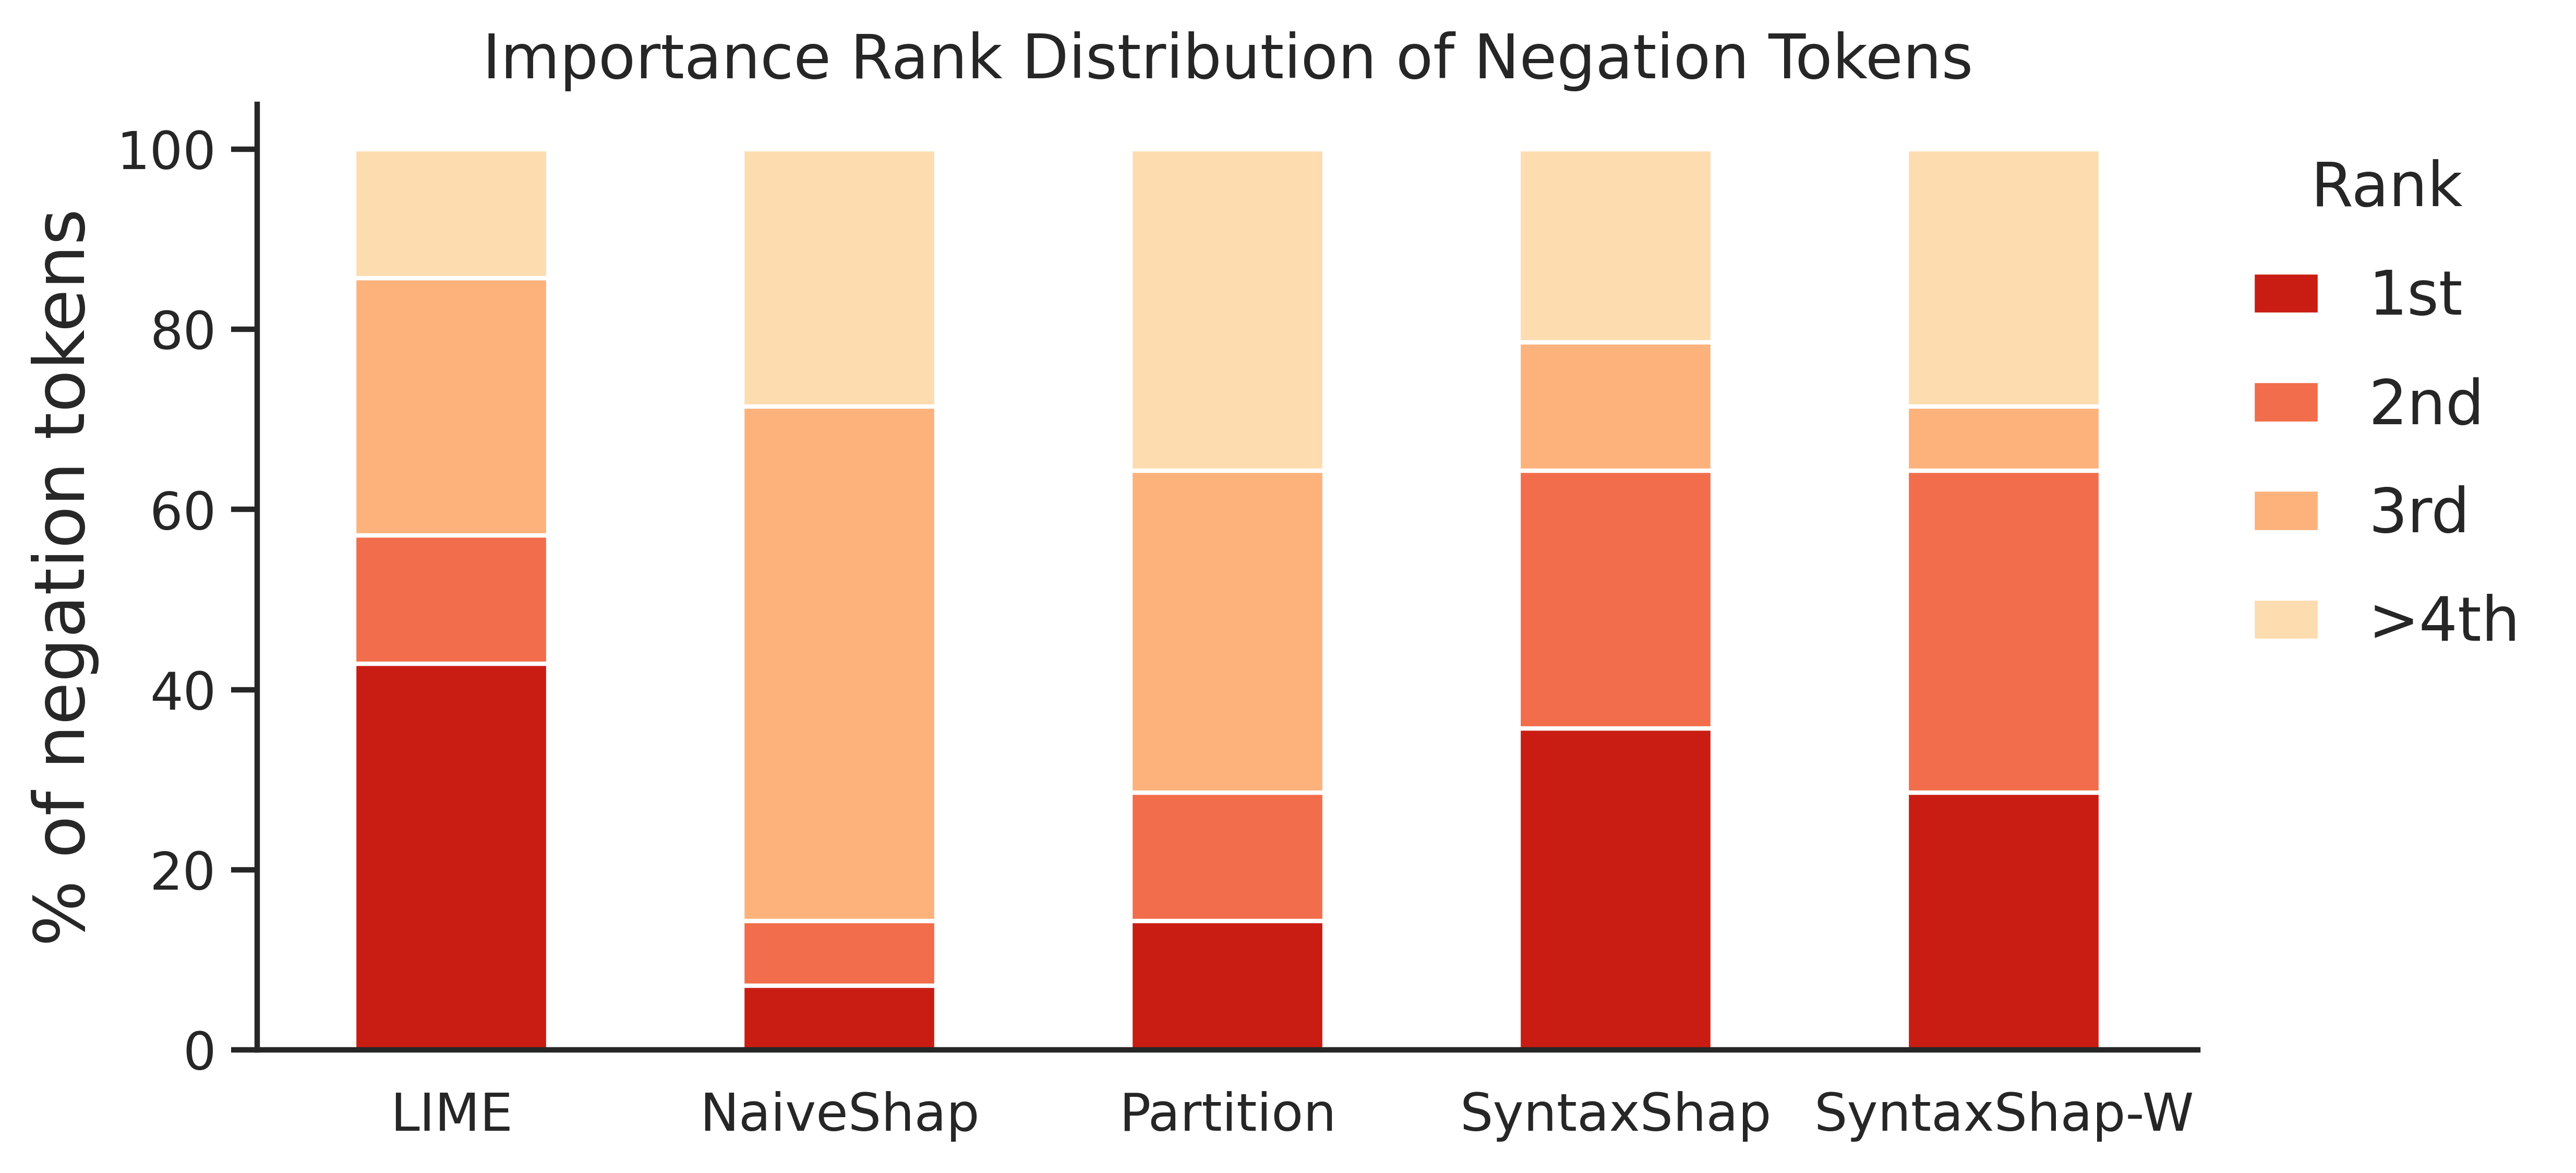

In [100]:

df = sample_with_y

# Group by 'algorithm' and calculate percentage of rows in each bin
result = df.groupby('algorithm')['neg_rank'].apply(lambda x: pd.cut(x, bins=[1, 2, 3, 4, float('inf')], right=False).value_counts(normalize=True) * 100).unstack().fillna(0)
#result.reset_index(inplace=True)
# Reorder rows and rename index
result = result.rename(index={'lime': 'LIME', 'shap': 'NaiveShap', 'partition': 'Partition', 'syntax': 'SyntaxShap', 'syntax-w': 'SyntaxShap-W'})
result = result.reindex(['LIME', 'NaiveShap', 'Partition', 'SyntaxShap', 'SyntaxShap-W'])

print(result)


sns.set_style("ticks")
sns.set_context("notebook", rc={"xtick.labelsize" : 12, "ytick.labelsize" : 12})
# Plot with increasing hue from Viridis colormap
plt.figure(figsize=(4,4))
result.plot(kind='bar', stacked=True, color=sns.color_palette("OrRd_r", n_colors=len(result.columns)), width=0.5, edgecolor='white', figsize=(8,4))

plt.title('Importance Rank Distribution of Negation Tokens', fontsize=14)
plt.xlabel('')
plt.ylabel('% of negation tokens', fontsize=16)
plt.xticks(rotation=0)
# Remove x ticks
plt.tick_params(axis='x', which='both', bottom=False)

# Move the legend outside on the upper right side of the plot
# Rewrite legend with custom labels and title
leg = plt.legend(labels=['1st', '2nd', '3rd', '>4th'], title='Rank', bbox_to_anchor=(1, 1), fontsize=14, loc='upper left', frameon=False, handlelength=1.1, labelspacing=0.8)
leg.get_title().set_fontsize('14')  # Increase legend title font size
for line in leg.get_lines():
    line.set_linewidth(3)  # Increase line width in legend

sns.despine()

#plt.tight_layout()
print(result)
plt.savefig(f"{root_dir}/figures/semantic_analysis/{dataset}_{model_name}_seed_{seed_}_negation_ranks.png", bbox_inches='tight', dpi=600)
plt.show()


In [226]:
df_neg = sample_with_y.groupby(['algorithm']).mean().reset_index()
df_neg

,algorithm,input_id,n_token,fid_keep_rd,fid_keep,fid_rmv,log_odds_keep,acc_at_k,prob_diff_at_k,label,neg_val,neg_rank
0,lime,285.142857,5.142857,0.097140,0.097140,0.085650,-10.600668,0.035714,0.555829,0.0,0.834892,2.142857
1,partition,285.142857,5.142857,0.070362,0.083303,0.092514,-6.929546,0.250000,0.422241,0.0,0.548672,3.000000
2,shap,285.142857,5.142857,0.094444,0.080564,0.094957,-6.916637,0.121429,0.508377,0.0,0.384876,3.285714
3,syntax,285.142857,5.142857,0.087937,0.081290,0.090669,-5.616655,0.214286,0.393510,0.0,0.567398,2.285714
4,syntax-w,285.142857,5.142857,0.082378,0.090344,0.089458,-7.184130,0.150000,0.453434,0.0,0.473569,2.428571


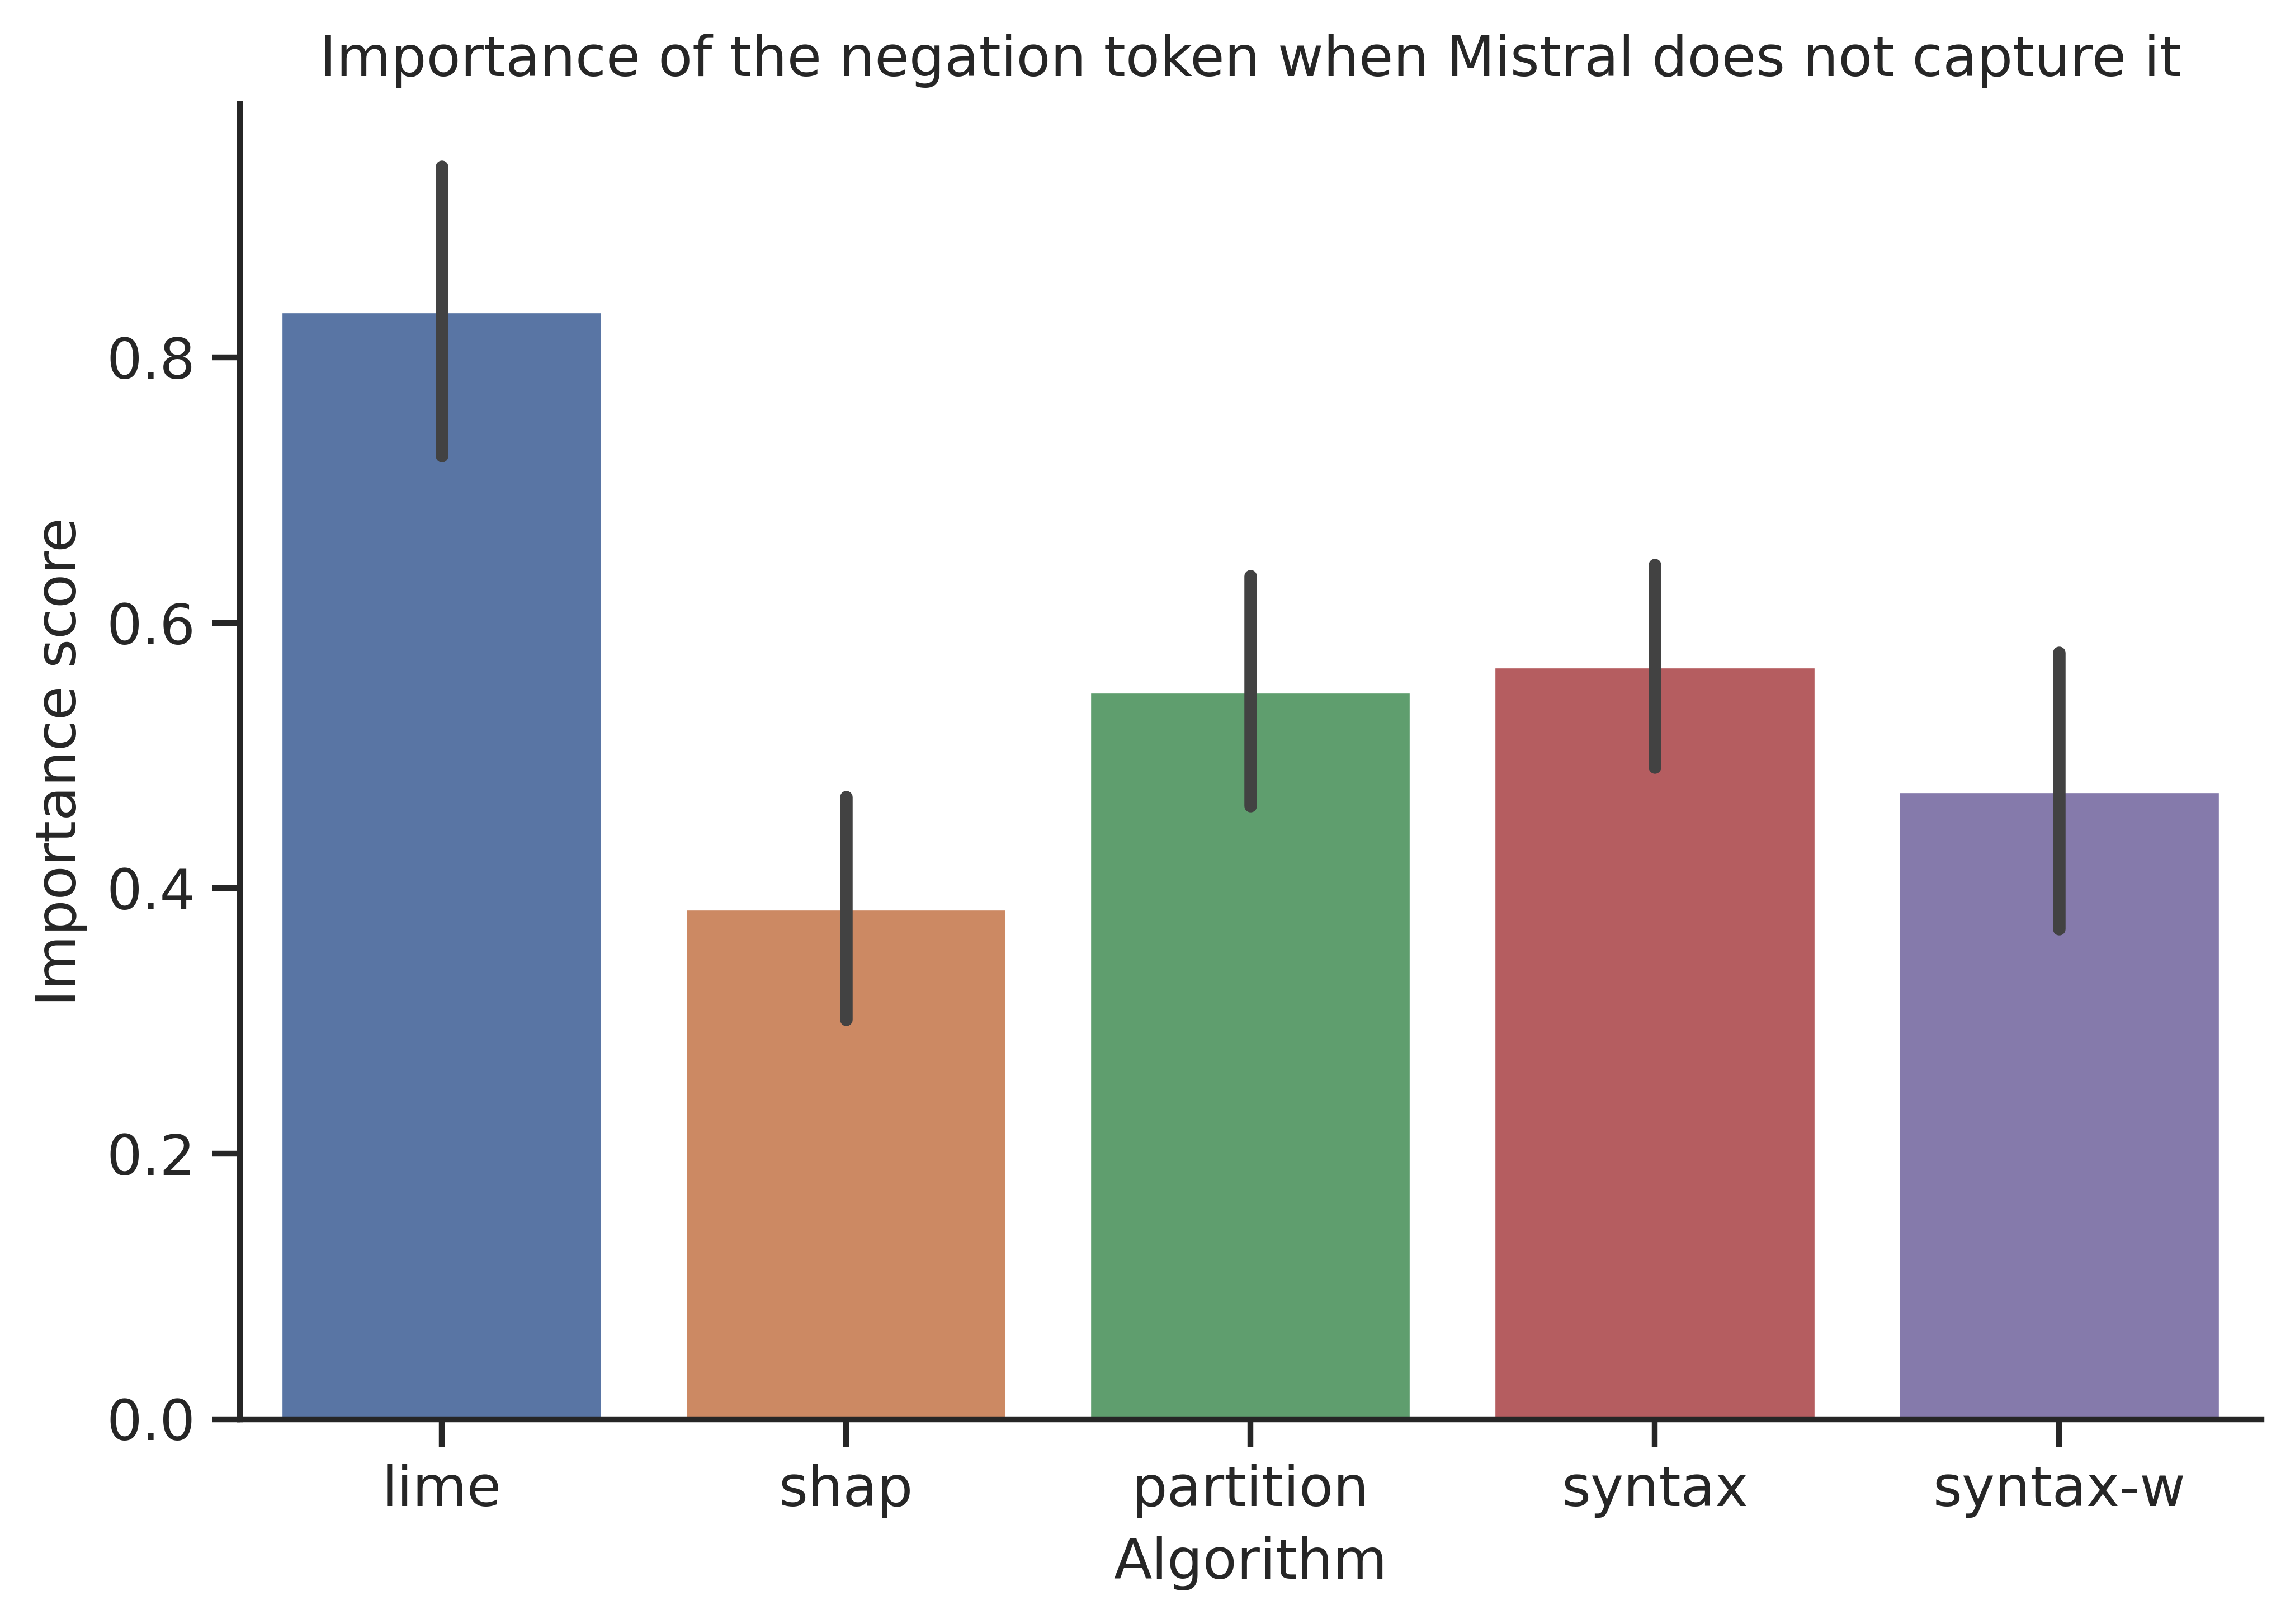

In [227]:
# Plot
df = sample_with_y

# Define the order of algorithms and a colormap
algo_order = ["lime", "shap", "partition", "syntax", "syntax-w"]
palette = sns.color_palette("tab10", len(algo_order))

# Ensure 'algorithm' column is categorical and ordered
df['algorithm'] = pd.Categorical(df['algorithm'], categories=algo_order, ordered=True)


# Adjusting various parameters
# Plotting with Seaborn
sns.set_style("ticks")
sns.set_context("notebook", rc={"xtick.labelsize" : 12, "ytick.labelsize" : 12})


plt.figure(figsize=(7,5))
sns.barplot(data=df, x='algorithm', y='neg_val', errorbar='se')
plt.title('Importance of the negation token when Mistral does not capture it')
plt.xlabel('Algorithm')
plt.ylabel('Importance score')
sns.despine()
plt.tight_layout()

plt.savefig(f"{root_dir}/figures/semantic_analysis/{dataset}_{model_name}_seed_{seed_}_negation_importance.png", bbox_inches='tight', dpi=600)

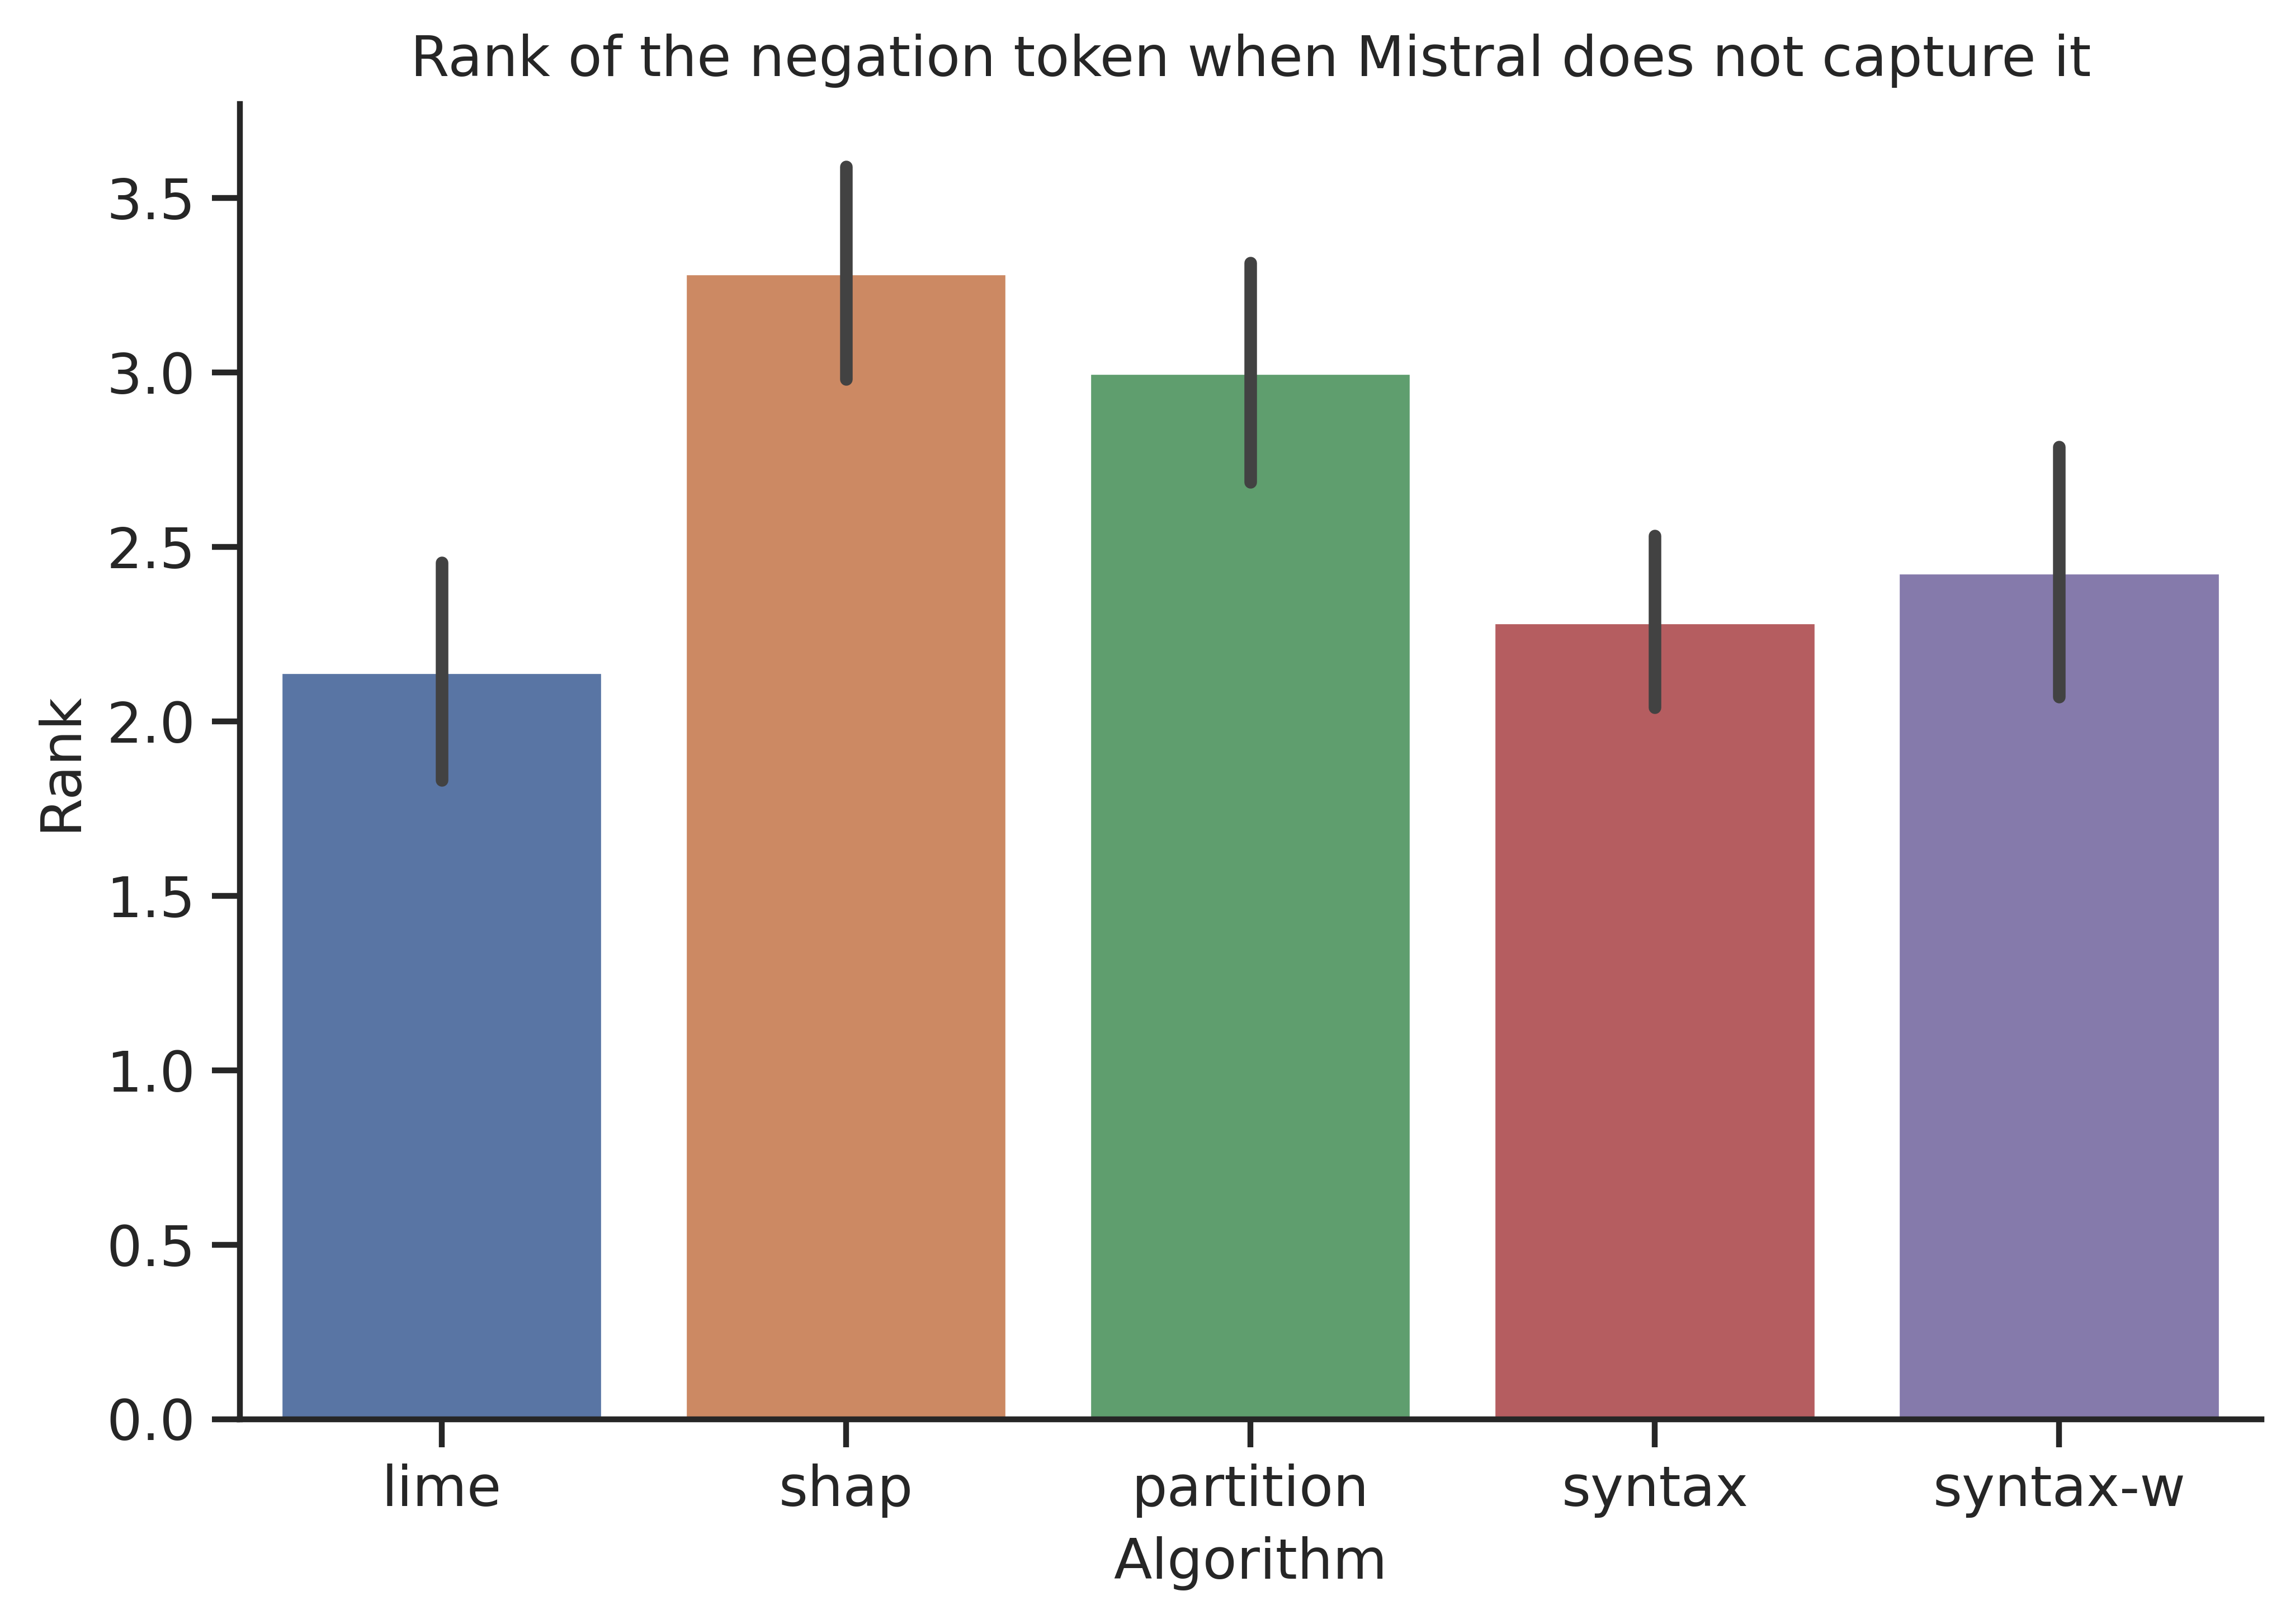

In [228]:
# Plot
df = sample_with_y

# Define the order of algorithms and a colormap
algo_order = ["lime", "shap", "partition", "syntax", "syntax-w"]
palette = sns.color_palette("tab10", len(algo_order))

# Ensure 'algorithm' column is categorical and ordered
df['algorithm'] = pd.Categorical(df['algorithm'], categories=algo_order, ordered=True)


# Adjusting various parameters
# Plotting with Seaborn
sns.set_style("ticks")
sns.set_context("notebook", rc={"xtick.labelsize" : 12, "ytick.labelsize" : 12})


plt.figure(figsize=(7,5))
sns.barplot(data=df, x='algorithm', y='neg_rank', errorbar='se')
plt.title('Rank of the negation token when Mistral does not capture it')
plt.xlabel('Algorithm')
plt.ylabel('Rank')
sns.despine()
plt.tight_layout()

plt.savefig(f"{root_dir}/figures/semantic_analysis/{dataset}_{model_name}_seed_{seed_}_negation_rank.png", bbox_inches='tight', dpi=600)

In [61]:
#for i in selected_indices:
i = selected_indices[0]
instance = sample_with_y[sample_with_y['input_id']==i]
info = instance.groupby(['input_id', 'input', 'y', 'label', 'n_token']).mean().reset_index()
print("input_id: ", info['input_id'])
print("input: ", info['input'])  
instance['tokens'] = instance['input'].apply(lambda x: x.split())
df = instance[['tokens', 'explanation', 'algorithm']]
df = df.apply(pd.Series.explode)
df['rank'] = df.groupby('algorithm')['explanation'].transform(lambda x: x.rank())



    #df#.pivot(index='tokens', columns='algorithm', values='explanation').plot(kind='bar', stacked=True)
    

input_id:  0    2
Name: input_id, dtype: int64
input:  0    A girl is not a
Name: input, dtype: object


/tmp/ipykernel_26212/2115529381.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  instance['tokens'] = instance['input'].apply(lambda x: x.split())


<AxesSubplot:xlabel='tokens', ylabel='rank'>

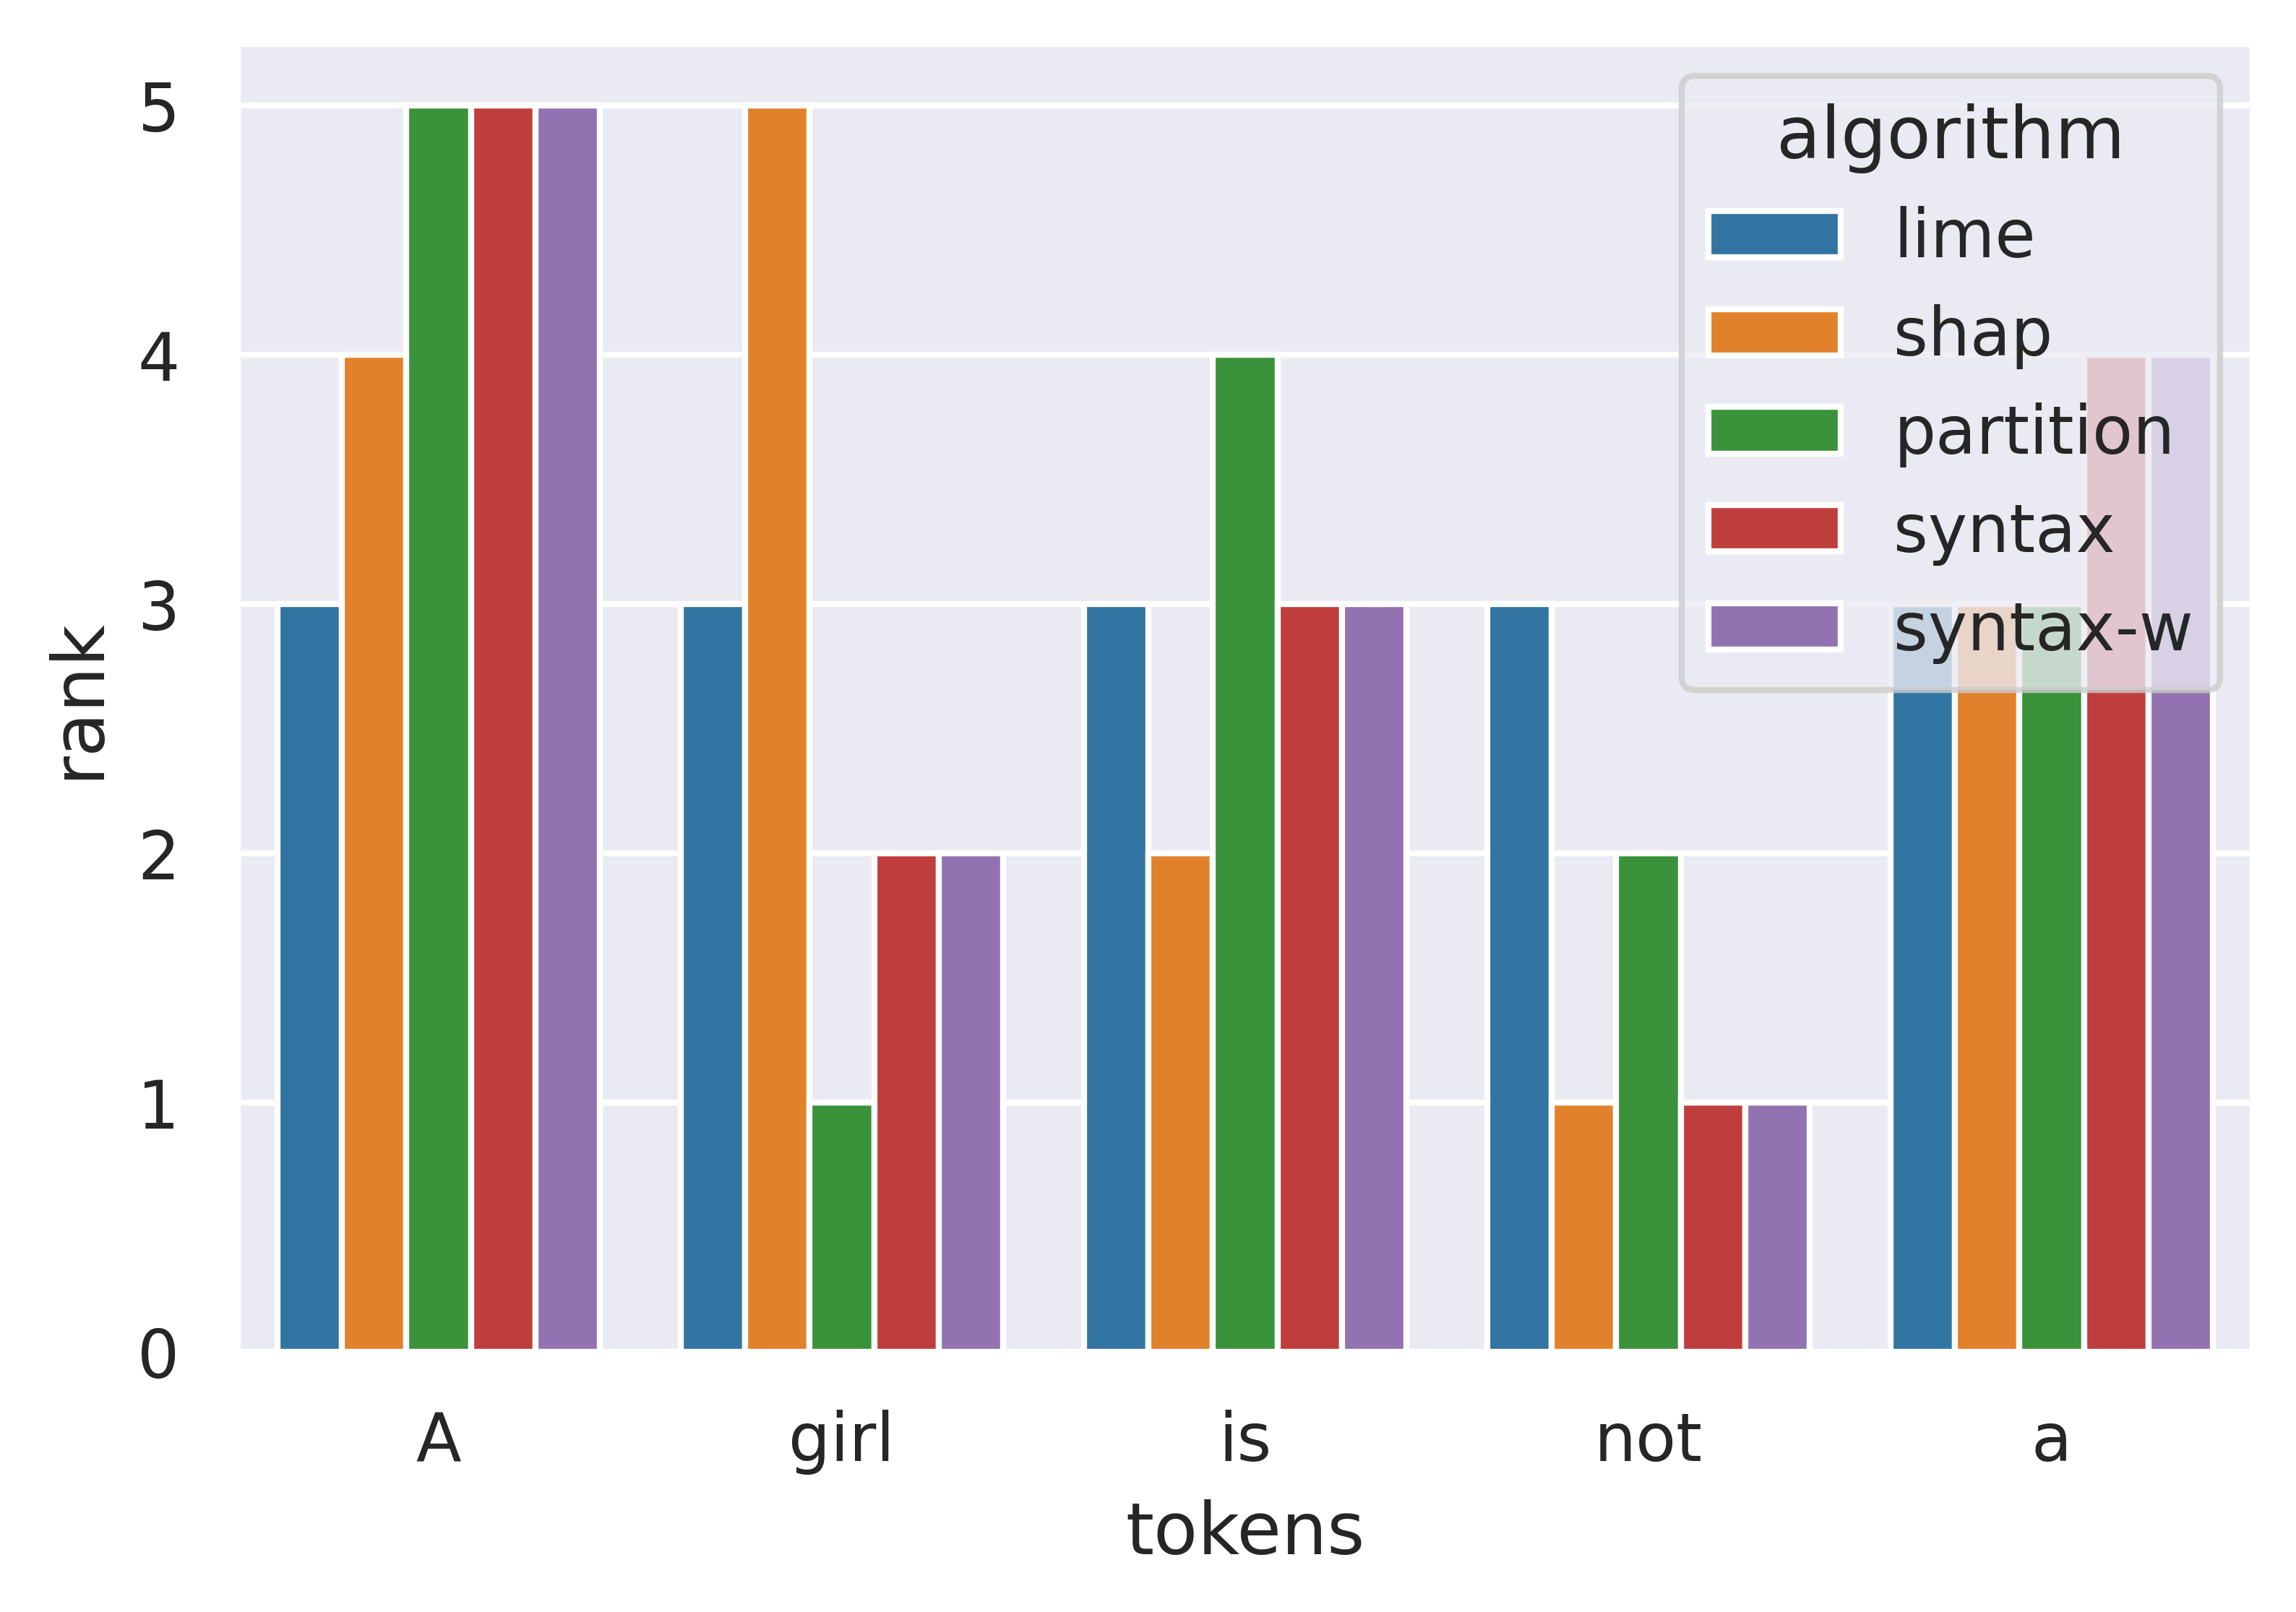

In [62]:

# Define the order of algorithms and a colormap
algo_order = ["lime", "shap", "partition", "syntax", "syntax-w"]
palette = sns.color_palette("tab10", len(algo_order))

# Ensure 'algorithm' column is categorical and ordered
df['algorithm'] = pd.Categorical(df['algorithm'], categories=algo_order, ordered=True)

sns.barplot(x='tokens', y='rank', hue='algorithm', data=df, palette=palette)


In [68]:
df

,tokens,explanation,algorithm,rank,inv_rank
15,A,1011.0,partition,5.0,1.0
15,girl,-15591.0,partition,1.0,5.0
15,is,-7770.0,partition,4.0,2.0
15,not,-10870.0,partition,2.0,4.0
15,a,-9509.0,partition,3.0,3.0
16,A,0.627284,syntax-w,5.0,1.0
16,girl,-0.010315,syntax-w,2.0,4.0
16,is,0.071414,syntax-w,3.0,3.0
16,not,-0.030519,syntax-w,1.0,5.0
16,a,0.342136,syntax-w,4.0,2.0


/tmp/ipykernel_26212/3307771496.py:13: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(new_labels)


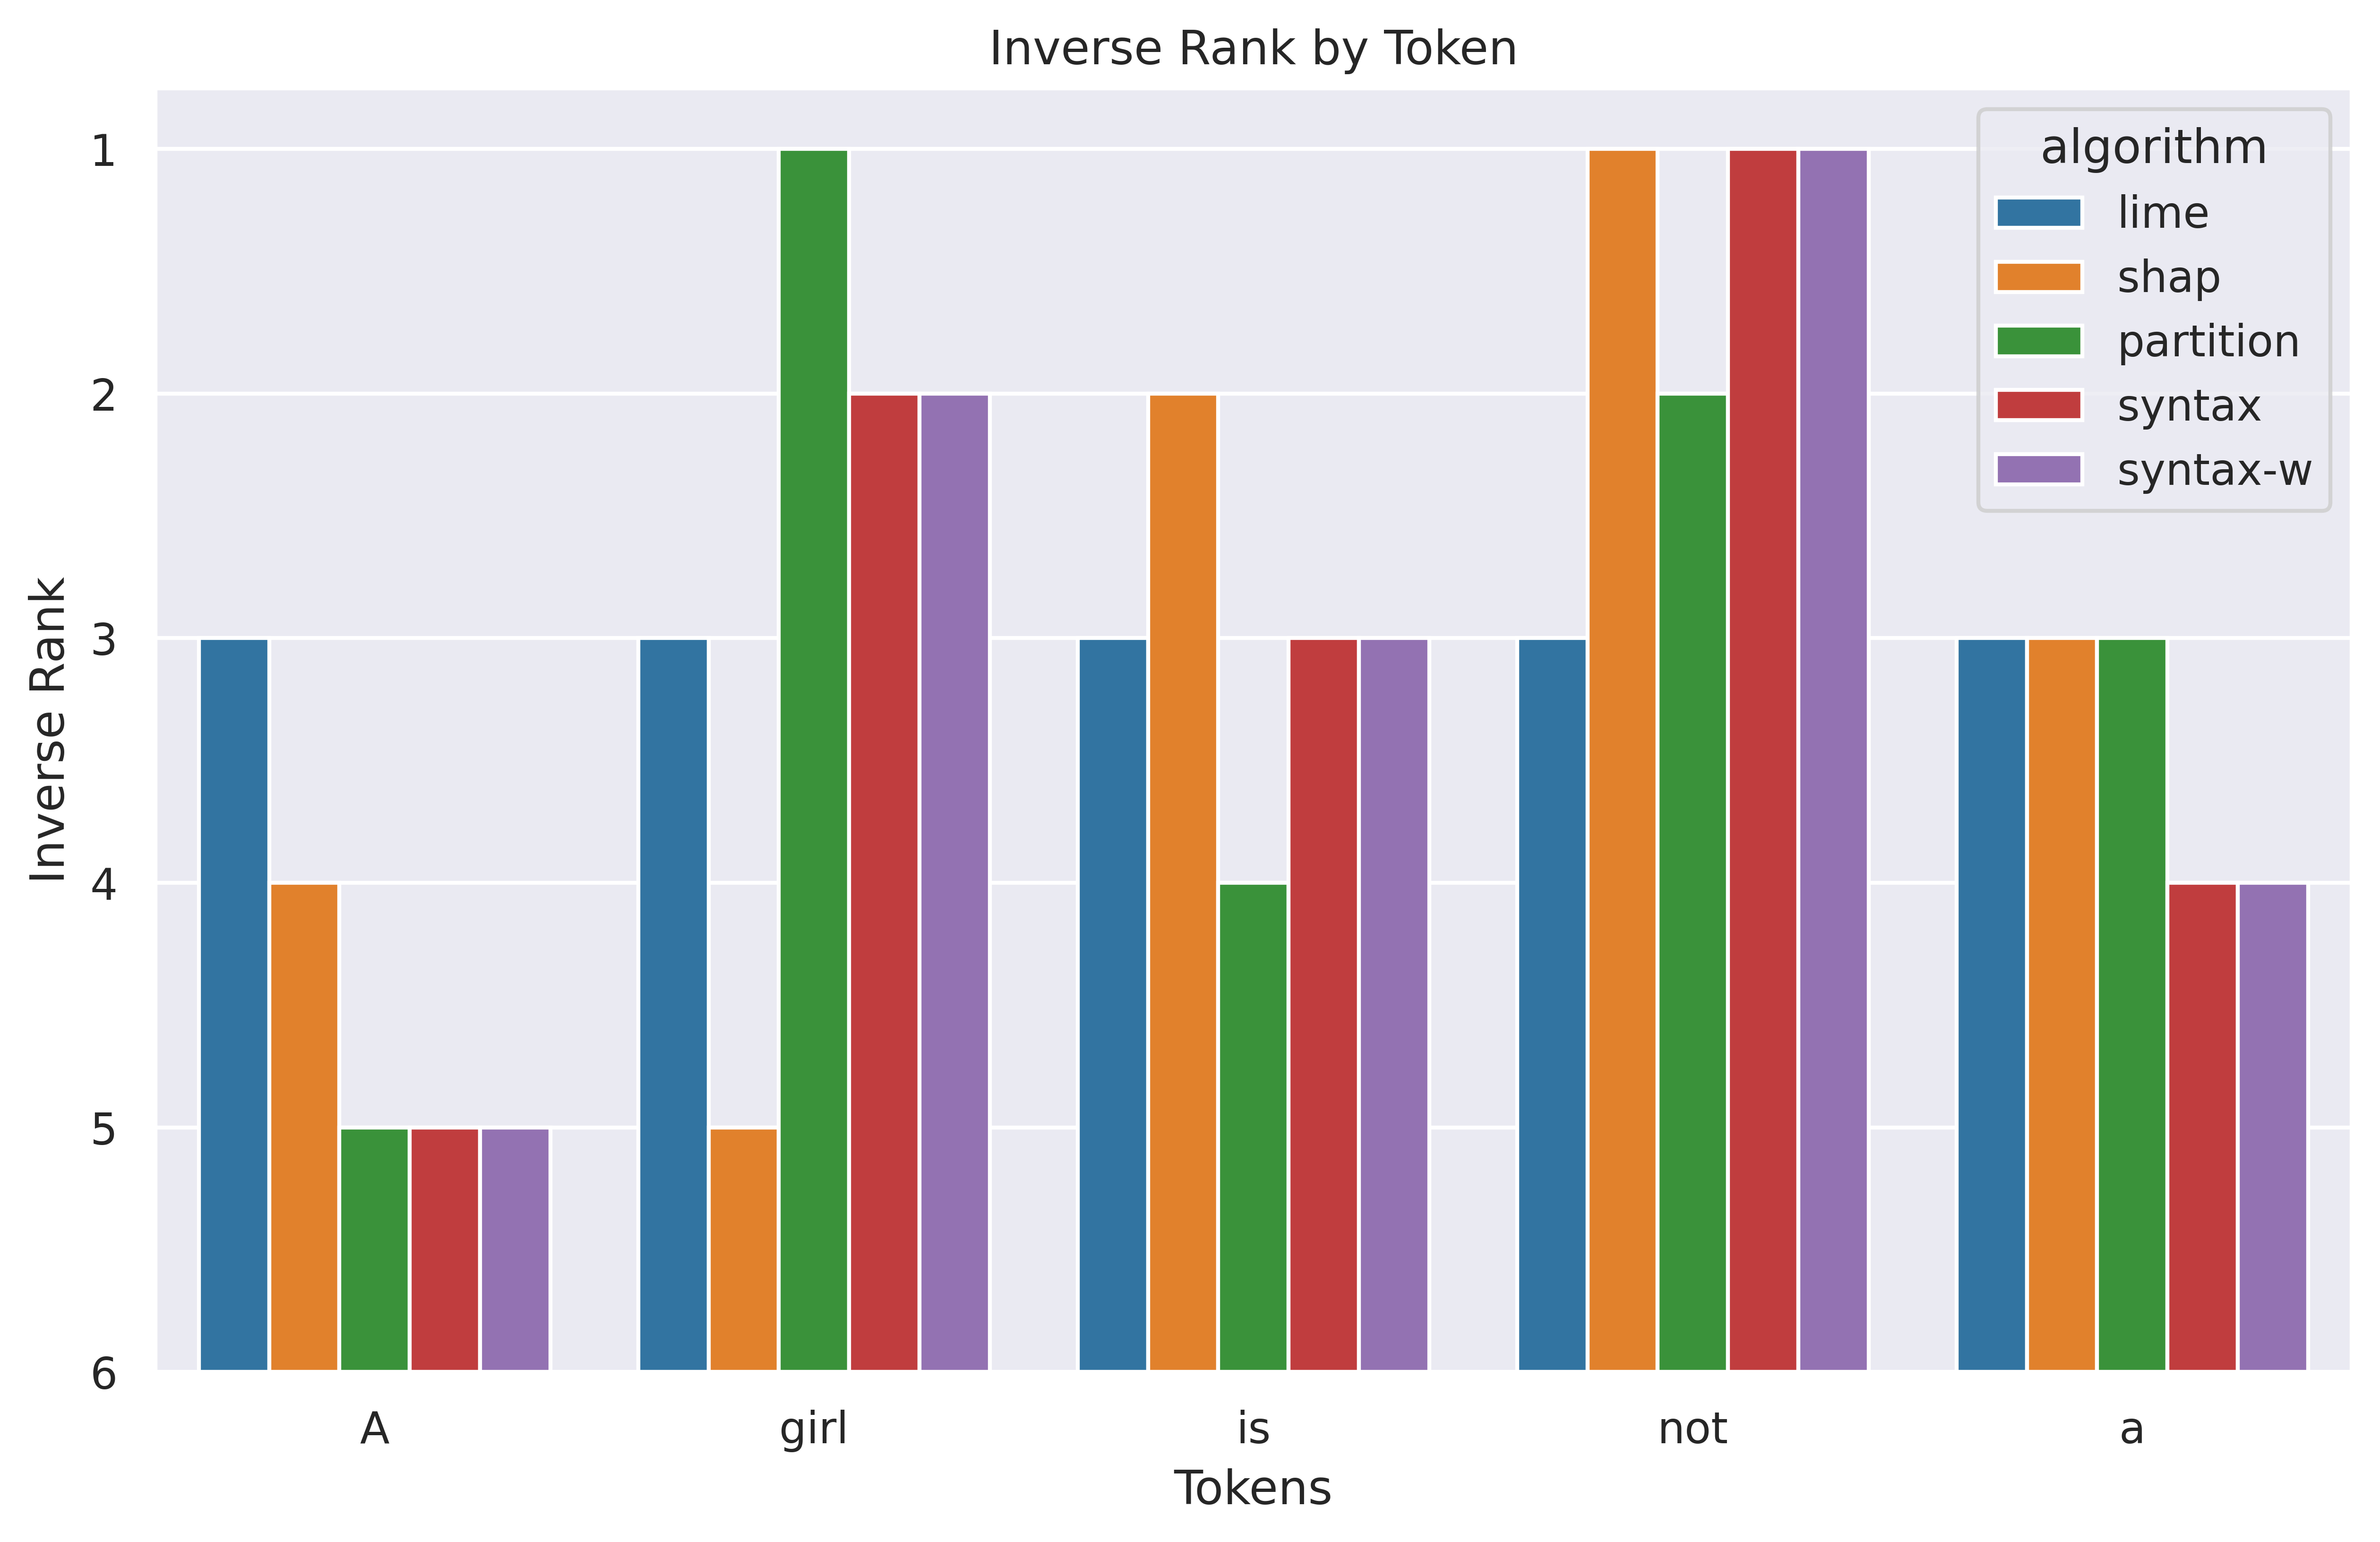

In [78]:
# Inverse the rank
max_rank = 5
df['inv_rank'] = max_rank - df['rank'] + 1  # Adding 1 to start the rank from 1 instead of 0

# Plot
plt.figure(figsize=(10, 6))
ax = sns.barplot(x='tokens', y='inv_rank', hue='algorithm', data=df, palette=palette)


# Relabel the y-axis
num_ticks = df['inv_rank'].nunique()
new_labels = [str(i) for i in range(num_ticks+1, 0, -1)]  # Reverse order
ax.set_yticklabels(new_labels)

plt.title('Inverse Rank by Token')
plt.xlabel('Tokens')
plt.ylabel('Inverse Rank')
plt.show()